In [1]:
%load_ext autoreload


In [2]:
%autoreload 2

In [21]:
import warnings
warnings.filterwarnings("ignore")

In [24]:
# Import necessary libraries
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt

sys.path.append("../scripts/")


In [25]:

# Import the custom modules
from data_preparation import load_data, plot_time_series
from model_training import train_arima_model, train_sarima_model, train_lstm_model
from forecasting import forecast_prices, forecast_sarima, forecast_lstm, evaluate_model


In [26]:

# Step 1: Load the Data
file_path = '../data/TSLA_historical_data.csv'
data = load_data(file_path)


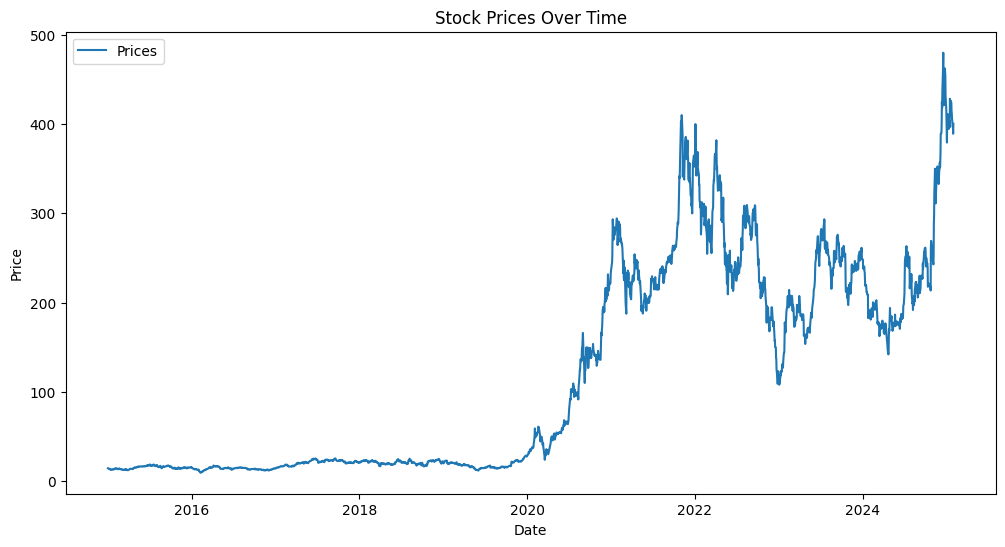

In [27]:

# Step 2: Plot the Time Series
plot_time_series(data['Close'], title='Stock Prices Over Time')


In [28]:

# Step 3: Split the Dataset
train_size = int(len(data) * 0.8)
train, test = data['Close'][:train_size], data['Close'][train_size:]


In [29]:

# Step 4: Train the ARIMA Model
model_fit_arima = train_arima_model(train)
forecast_arima = forecast_prices(model_fit_arima, steps=len(test))


Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=12684.802, Time=0.90 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=12680.726, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=12679.653, Time=0.14 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=12679.753, Time=0.20 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=12678.997, Time=0.05 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=12680.805, Time=0.54 sec

Best model:  ARIMA(0,1,0)(0,0,0)[0]          
Total fit time: 1.875 seconds


In [30]:

# Step 5: Train the SARIMA Model
seasonal_order = (1, 1, 1, 12)  # Adjust based on your data's seasonality
model_fit_sarima = train_sarima_model(train, seasonal_order)
forecast_sarima = forecast_sarima(model_fit_sarima, steps=len(test))


In [31]:

# Step 6: Train the LSTM Model
lstm_model, scaler = train_lstm_model(train)
forecast_lstm = forecast_lstm(lstm_model, scaler, test)


Epoch 1/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 5s 9ms/step - loss: 0.0433
Epoch 2/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0024
Epoch 3/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019
Epoch 4/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016
Epoch 5/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017
Epoch 6/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017
Epoch 7/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0016
Epoch 8/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0017
Epoch 9/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0018
Epoch 10/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019
Epoch 11/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0019
Epoch 12/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0014
Epoch 13/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - loss: 0.0015
Epoch 14/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - loss: 0.0015
Epoch 15/100
64/64 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - loss: 0.0012
E

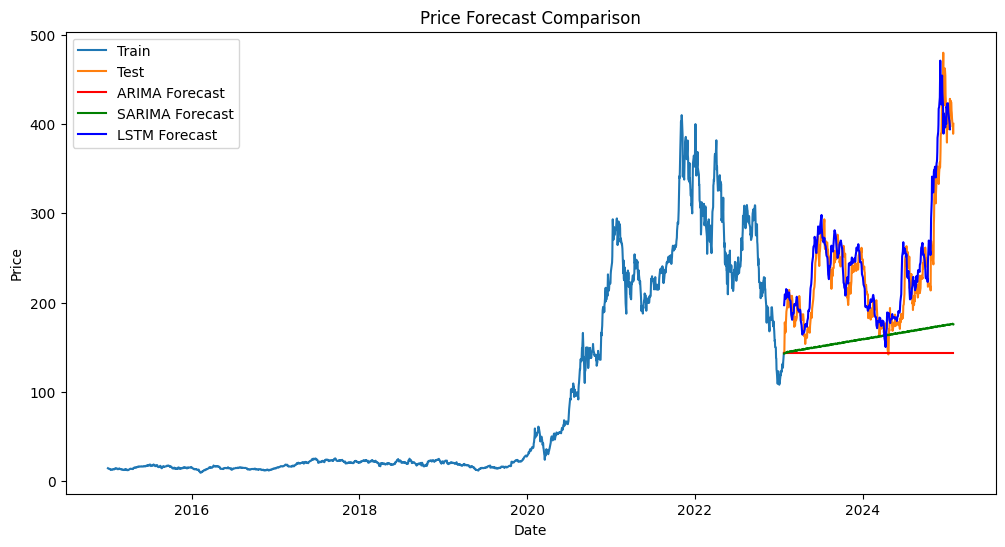

In [32]:
# Step 7: Plot the Forecasts

# Ensure LSTM forecast is a 1D array
forecast_lstm = forecast_lstm.ravel()

# Adjust lengths to match test.index
min_length = min(len(test.index), len(forecast_lstm))
forecast_lstm = forecast_lstm[:min_length]
test_index = test.index[:min_length]

# Plot the forecasts
plt.figure(figsize=(12, 6))
plt.plot(train, label='Train')
plt.plot(test, label='Test')
plt.plot(test.index, forecast_arima, label='ARIMA Forecast', color='red')
plt.plot(test.index, forecast_sarima, label='SARIMA Forecast', color='green')
plt.plot(test_index, forecast_lstm, label='LSTM Forecast', color='blue')

plt.title('Price Forecast Comparison')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()



In [33]:
import numpy as np
forecast_arima = np.nan_to_num(forecast_arima, nan=0.0)  # Replace NaN with 0
forecast_sarima = np.nan_to_num(forecast_sarima, nan=0.0)

In [34]:
# Step 8: Evaluate the Models

forecast_lstm = forecast_lstm.ravel()

# Align the test data with the LSTM output length
test_aligned = test.iloc[:len(forecast_lstm)]

# Evaluate models
mae_arima, rmse_arima, mape_arima = evaluate_model(test, forecast_arima)
mae_sarima, rmse_sarima, mape_sarima = evaluate_model(test, forecast_sarima)
mae_lstm, rmse_lstm, mape_lstm = evaluate_model(test_aligned, forecast_lstm)

print(f'ARIMA - MAE: {mae_arima}, RMSE: {rmse_arima}, MAPE: {mape_arima}')
print(f'SARIMA - MAE: {mae_sarima}, RMSE: {rmse_sarima}, MAPE: {mape_sarima}')
print(f'LSTM - MAE: {mae_lstm}, RMSE: {rmse_lstm}, MAPE: {mape_lstm}')


ARIMA - MAE: 89.90958562546228, RMSE: 111.07844416791498, MAPE: 34.614067420672825
SARIMA - MAE: 73.9150818530549, RMSE: 95.715434186142, MAPE: 27.814916599936613
LSTM - MAE: 20.67299082581426, RMSE: 27.160412393805352, MAPE: 9.159787652524896
